In [1]:
import os
import time
import pickle
import numpy as np

import torch
from torch import nn
from accelerate import Accelerator

import util as U
from spender import SpectrumAutoencoder
from spender.data import desi_qso as desi 

/home/chhahn/projects/spender_qso/bin/london/util.py:24: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _trapz_rebin(x, y, edges, results):


In [2]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
print("torch.cuda.device_count():",torch.cuda.device_count())

torch.cuda.device_count(): 1


In [4]:
niter = 0

In [5]:
def load_model(filename, models, instruments):
    device = instruments[0].wave_obs.device
    model_struct = torch.load(filename, map_location=device)
    #wave_rest = model_struct['model'][0]['decoder.wave_rest']
    
    for i, model in enumerate(models):
        # backwards compat: encoder.mlp instead of encoder.mlp.mlp
        if 'encoder.mlp.mlp.0.weight' in model_struct['model'][i].keys():
            from collections import OrderedDict
            model_struct['model'][i] = OrderedDict([(k.replace('mlp.mlp', 'mlp'), v) for k, v in model_struct['model'][i].items()])
        # backwards compat: add instrument to encoder
        try:
            model.load_state_dict(model_struct['model'][i], strict=False)
        except RuntimeError:
            model_struct['model'][i]['encoder.instrument.wave_obs']= instruments[i].wave_obs
            #model_struct['model'][i]['encoder.instrument.skyline_mask']= instruments[i].skyline_mask
            model.load_state_dict(model_struct[i]['model'], strict=False)

    losses = model_struct['losses']
    return models, losses

In [6]:
# define instruments
instruments = [ desi.DESI() ]

In [7]:
latents = 10 
z_min, z_max = 2.1, 3.5

# restframe wavelength for reconstructed spectra
# Note: represents joint dataset wavelength range
lmbda_min = instruments[0].wave_obs[0]/(1.0+z_max) # 2000 A
lmbda_max = instruments[0].wave_obs[-1]/(1.0+z_min) # 9824 A
bins = 9780
wave_rest = torch.linspace(lmbda_min, lmbda_max, bins, dtype=torch.float32)

# define and train the model
n_hidden = (64, 256, 1024)
models = [ SpectrumAutoencoder(instrument,
                               wave_rest,
                               n_latent=latents,
                               n_hidden=n_hidden,
                               act=[nn.LeakyReLU()]*(len(n_hidden)+1)
                               )
          for instrument in instruments ]

In [8]:
models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.1sigma.iter%i.pt' % niter, models, instruments)

In [9]:
ibatch = 0 
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.1sigma.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)

In [10]:
true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))

In [11]:
with torch.no_grad():
    models[0].eval()
    instruments[0].eval()

    s = models[0].encode(spec)
    spec_rest = models[0].decode(s)

/home/chhahn/projects/spender_qso/bin/london/util.py:23: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_trapz_rebin" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/chhahn/projects/spender_qso/bin/london/util.py (23)

File "util.py", line 23:
def centers2edges(centers):
    <source elided>

@numba.jit
^

  @numba.jit
/home/chhahn/projects/spender_qso/bin/london/util.py:23: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_trapz_rebin" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "util.py", line 69:
def _trapz_rebin(x, y, edges, results):
    <source elided>

    for i in range(nbin):
    ^

  @numba.jit
/home/chhahn/.conda/envs/gqp/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "_trapz_rebin" was compiled in object mode without f

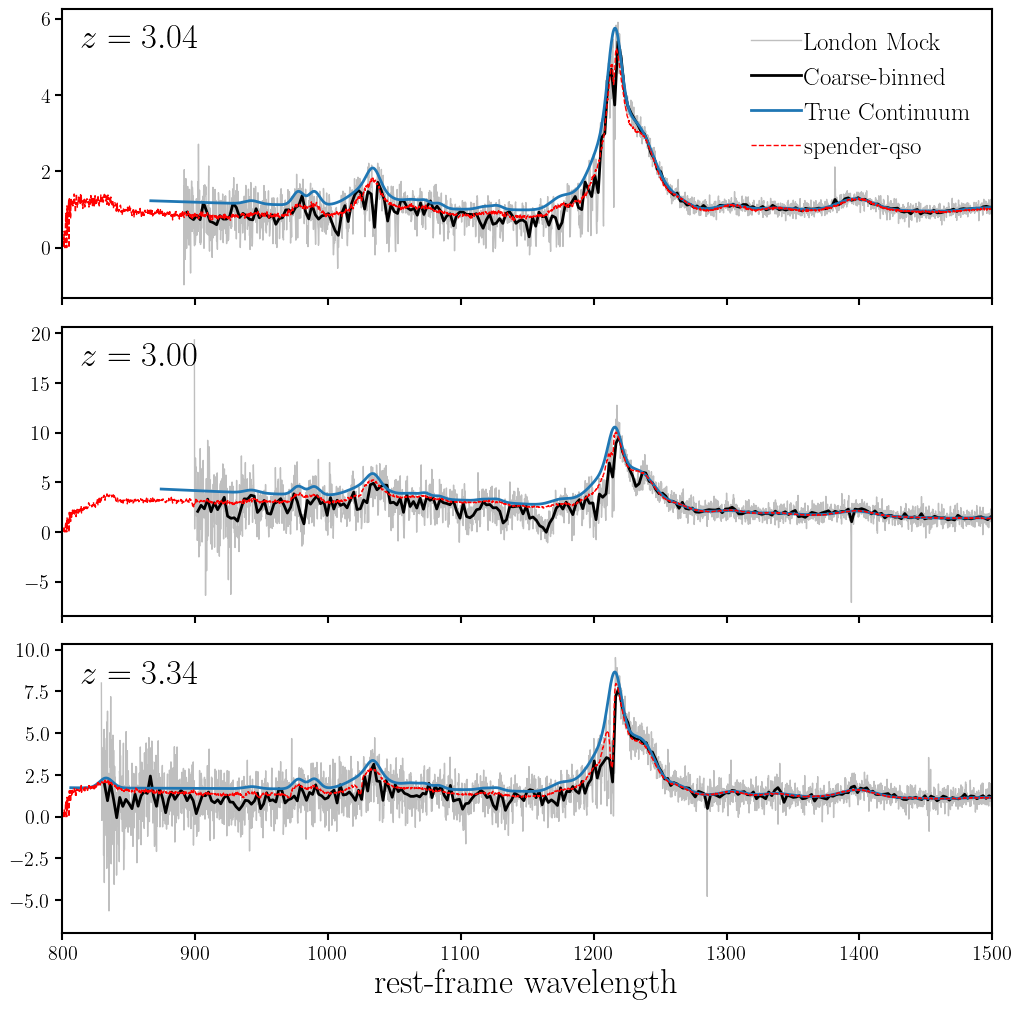

In [12]:
highzs = np.arange(len(z))[z > 3.0][22:25]

fig = plt.figure(figsize=(12,4*len(highzs)))

wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate(highzs):
    sub = fig.add_subplot(len(highzs), 1, ii+1)
    sub.plot(models[0].wave_obs/(1 + z[igal]), spec[igal], c='gray', alpha=0.5, lw=1, label='London Mock')

    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), spec[igal], xnew=wave_rebin)
    sub.plot(wave_rebin/(1+z[igal]), spec_rebin, c='k', lw=2, label='Coarse-binned')

    sub.plot(np.linspace(3.50e3, 1e4, 3251)/(1 + z[igal]), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Continuum')
    sub.plot(models[0].wave_rest, spec_rest[igal], color='r', lw=1, ls='--', label='spender-qso')
    
    
    #sub.axvline(1215.*(1+z[igal]), linestyle='--', color='k')

    sub.text(0.02, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=25, transform=sub.transAxes)

    sub.set_xlim(models[0].wave_rest[0], 1500.)#models[0].wave_rest[-1])
    if ii < len(highzs)-1: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', fontsize=18, handletextpad=0.1)
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

95
525
393


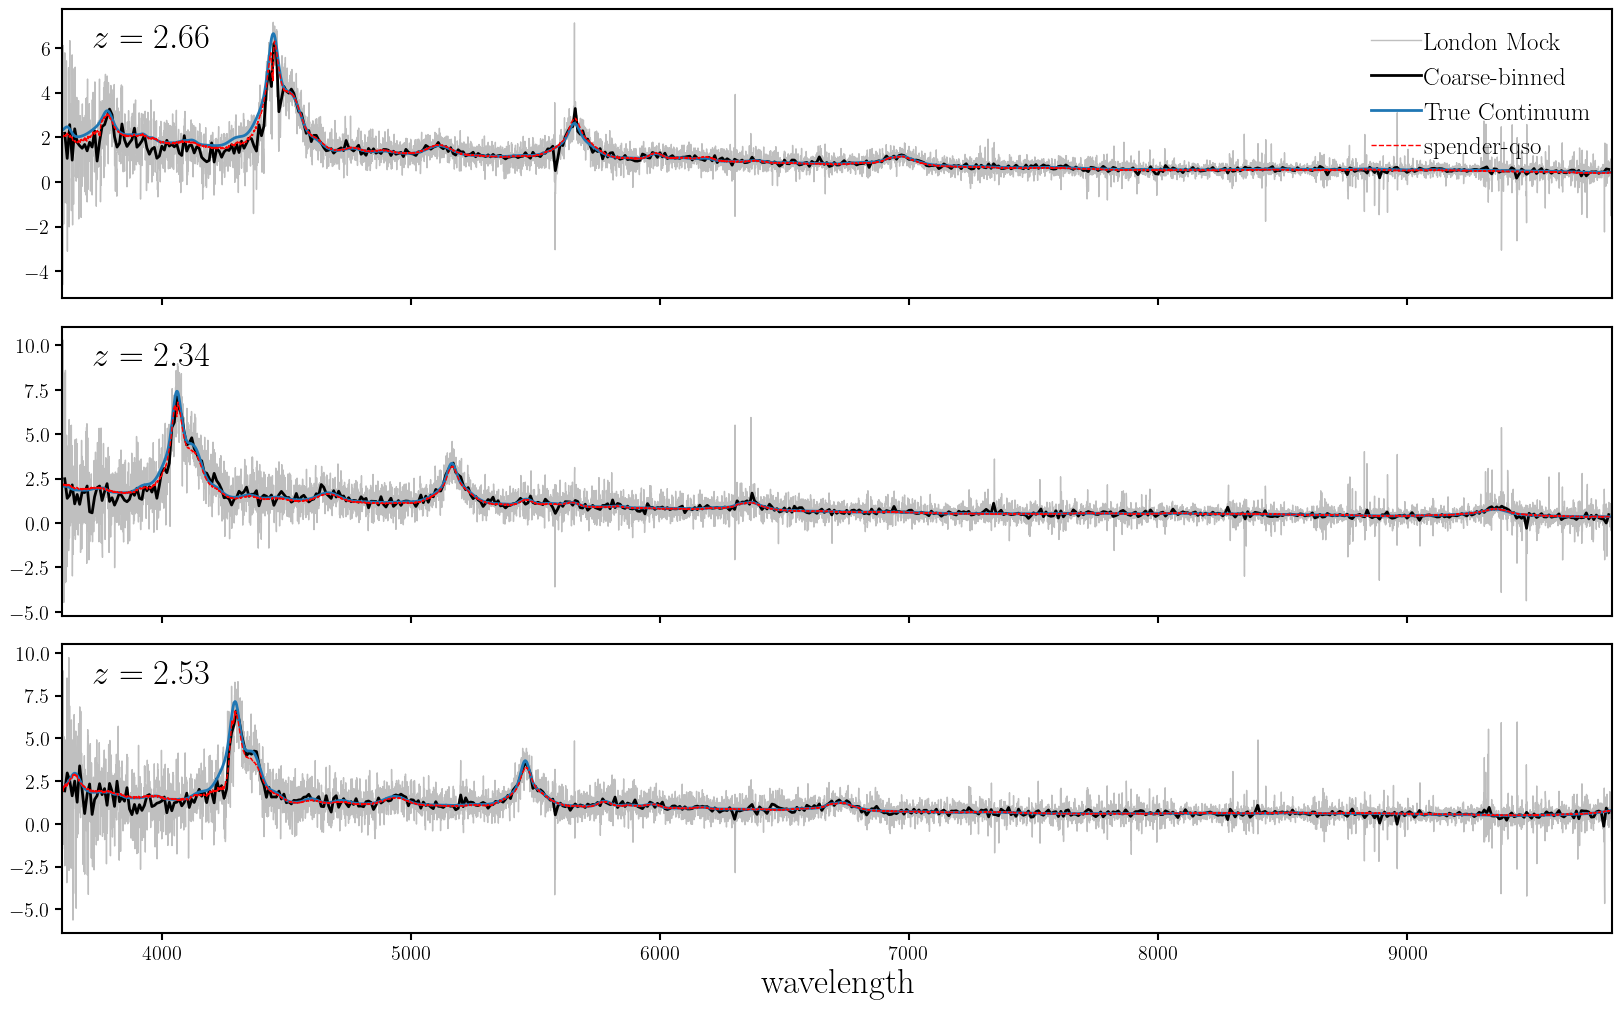

In [13]:
fig = plt.figure(figsize=(20,12))

wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate([95, 525, 393]): #np.random.choice(np.arange(len(z)), size=3, replace=False)):
    print(igal)
    sub = fig.add_subplot(len(highzs), 1, ii+1)
    sub.plot(models[0].wave_obs, spec[igal], c='gray', alpha=0.5, lw=1, label='London Mock')

    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), spec[igal], xnew=wave_rebin)
    sub.plot(wave_rebin, spec_rebin, c='k', lw=2, label='Coarse-binned')

    sub.plot(np.linspace(3.50e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Continuum')
    sub.plot(models[0].wave_rest * (1+z[igal]), spec_rest[igal], color='r', lw=1, ls='--', label='spender-qso')
    
    
    #sub.axvline(1215.*(1+z[igal]), linestyle='--', color='k')

    sub.text(0.02, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=25, transform=sub.transAxes)

    sub.set_xlim(models[0].wave_obs[0], models[0].wave_obs[-1])#models[0].wave_rest[-1])
    if ii < len(highzs)-1: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', fontsize=18, handletextpad=0.1)
sub.set_xlabel("wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()